In [1]:
import pandas as pd

from genetic_program import FitnessFunction
from gp_artemis import ExperimentManager
from IPython.core.display import HTML, Javascript
from chart_plotter import DogeDNACanvas

%matplotlib inline
pd.set_option('display.max_columns', 500)

class WowFitnessFunction(FitnessFunction):
    _name = "ff_sowow"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent * evaluation.num_sells,

class BenchmarkDiffFitnessFunction(FitnessFunction):
    _name = "ff_benchmarkdiff"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent - evaluation.benchmark_backtest.profit_percent,
    
    
    
experiment_json = {
    "training_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/04/01 00:00:00 UTC",
        "end_time": "2018/06/01 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "validation_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/03/01 00:00:00 UTC",
        "end_time": "2018/03/31 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "fitness_function": "ff_benchmarkdiff",
    "grammar_version": "gv1",
    "num_generations": 3,

    "mating_probabilities": [
        0.5,
        0.7
    ],

    "mutation_probabilities": [
        0.7,
        0.8,
        0.9
    ],

    "population_sizes": [
        500
    ]
}

e = ExperimentManager(experiment_json, read_from_file=False)
e.run_experiments(display_results=False)


INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.8;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.5;mutationprob_0.9;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.7;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data

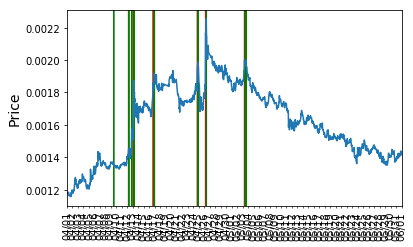

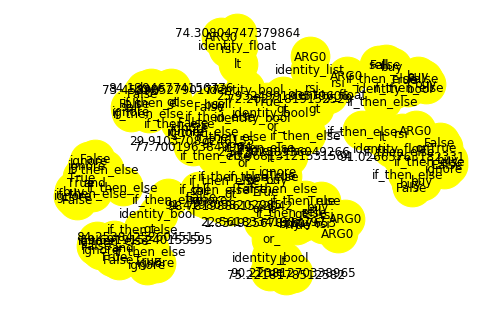

In [2]:
performance_df = e.analyze_and_find_best()

In [3]:
performance_df

,alpha,benchmark_profit_percent,benchmark_profit_percent_usdt,beta,buy_currency,cash,counter_currency,crypto,current_price,current_timestamp,end_cash,end_crypto,end_crypto_currency,end_price,end_time,end_value,end_value_usdt,evaluate_profit_on_last_order,evaluation,experiment_id,hof_ranking,individual,max_buy_sell_pair_gain,max_buy_sell_pair_loss,max_buy_sell_pair_return,max_drawdown,max_drawdown_duration,mean_buy_sell_pair_gain,mean_buy_sell_pair_loss,mean_buy_sell_pair_return,min_buy_sell_pair_gain,min_buy_sell_pair_loss,min_buy_sell_pair_return,num_buy_sell_pairs,num_buys,num_gains,num_losses,num_orders,num_profitable_trades,num_sells,num_trades,num_unprofitable_trades,percent_profitable_trades,profit,profit_percent,profit_percent_usdt,profit_usdt,resample_period,sharpe_ratio,slippage,source,start_cash,start_crypto,start_time,start_value,start_value_usdt,std_buy_sell_pair_gain,std_buy_sell_pair_loss,std_buy_sell_pair_return,time_delay,transaction_cost_percent,transaction_currency,verbose
44,-0.001187,14.261649,19.364172,0.854167,OMG,0.0,BTC,787726.552718,0.001415,1.527811e+09,0.0,787726.552718,OMG,0.001415,1.527811e+09,1114.459772,8.335069e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,4,"[<deap.gp.Primitive object at 0x11651d958>, <d...",0.180924,-0.076098,0.180924,-0.368624,2854800.0,0.071464,-0.076098,0.055068,0.004106,-0.076098,-0.076098,9,10,8,1,19,8,9,19,1,0.888889,114.459772,11.445977,20.448971,1.415069e+06,60,0.194833,0,0,1000,0,1.522541e+09,1000,6920000.0,0.051723,0.000000,0.067295,0,0.0025,OMG,False
40,-0.001187,14.261649,19.364172,0.854167,OMG,0.0,BTC,787726.552718,0.001415,1.527811e+09,0.0,787726.552718,OMG,0.001415,1.527811e+09,1114.459772,8.335069e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,0,"[<deap.gp.Primitive object at 0x11651d958>, <d...",0.180924,-0.076098,0.180924,-0.368624,2854800.0,0.071464,-0.076098,0.055068,0.004106,-0.076098,-0.076098,9,10,8,1,19,8,9,19,1,0.888889,114.459772,11.445977,20.448971,1.415069e+06,60,0.194833,0,0,1000,0,1.522541e+09,1000,6920000.0,0.051723,0.000000,0.067295,0,0.0025,OMG,False
51,-0.001187,14.261649,19.364172,0.854167,OMG,0.0,BTC,787726.552718,0.001415,1.527811e+09,0.0,787726.552718,OMG,0.001415,1.527811e+09,1114.459772,8.335069e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,1,"[<deap.gp.Primitive object at 0x11712ff98>, <d...",0.180924,-0.076098,0.180924,-0.368624,2854800.0,0.071464,-0.076098,0.055068,0.004106,-0.076098,-0.076098,9,10,8,1,19,8,9,19,1,0.888889,114.459772,11.445977,20.448971,1.415069e+06,60,0.194833,0,0,1000,0,1.522541e+09,1000,6920000.0,0.051723,0.000000,0.067295,0,0.0025,OMG,False
50,-0.001187,14.261649,19.364172,0.854167,OMG,0.0,BTC,787726.552718,0.001415,1.527811e+09,0.0,787726.552718,OMG,0.001415,1.527811e+09,1114.459772,8.335069e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,0,"[<deap.gp.Primitive object at 0x11712ff98>, <d...",0.180924,-0.076098,0.180924,-0.368624,2854800.0,0.071464,-0.076098,0.055068,0.004106,-0.076098,-0.076098,9,10,8,1,19,8,9,19,1,0.888889,114.459772,11.445977,20.448971,1.415069e+06,60,0.194833,0,0,1000,0,1.522541e+09,1000,6920000.0,0.051723,0.000000,0.067295,0,0.0025,OMG,False
49,-0.001187,14.261649,19.364172,0.854167,OMG,0.0,BTC,787726.552718,0.001415,1.527811e+09,0.0,787726.552718,OMG,0.001415,1.527811e+09,1114.459772,8.335069e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,9,"[<deap.gp.Primitive object at 0x11651d958>, <d...",0.180924,-0.076098,0.180924,-0.368624,2854800.0,0.071464,-0.076098,0.055068,0.004106,-0.076098,-0.076098,9,10,8,1,19,8,9,19,1,0.888889,114.459772,11.445977,20.448971,1.415069e+06,60,0.194833,0,0,1000,0,1.522541e+09,1000,6920000.0,0.051723,0.000000,0.067295,0,0.0025,OMG,False
48,-0.001187,14.261649,1

Experiment id: run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_benchmarkdiff;matingprob_0.7;mutationprob_0.8;populationsize_500;generations_3

String representation:
if_then_else(identity_bool(identity_bool(lt(rsi(ARG0), identity_float(74.30804747379864)))), if_then_else(gt(identity_float(rsi(ARG0)), rsi(identity_list(ARG0))), if_then_else(lt(identity_float(91.02665763182331), rsi(ARG0)), if_then_else(identity_bool(True), if_then_else(False, buy, buy), if_then_else(False, buy, sell)), if_then_else(or_(True, False), if_then_else(False, buy, ignore), if_then_else(False, buy, buy))), if_then_else(or_(gt(72.20271819152529, 25.932499193579606), identity_bool(True)), if_then_else(lt(22.56183341983797, 1.8349256783517653), if_then_else(True, sell, buy), if_then_else(True, buy, buy)), if_then_else(gt(29.91037087246155, 77.7001963849964), if_then_else(False, buy, sell), if_then_else(False, ignore, ignore)))), if_then_else(or_(gt(rsi(ARG0), rsi(ARG

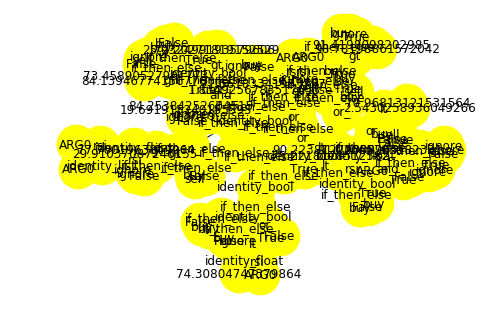

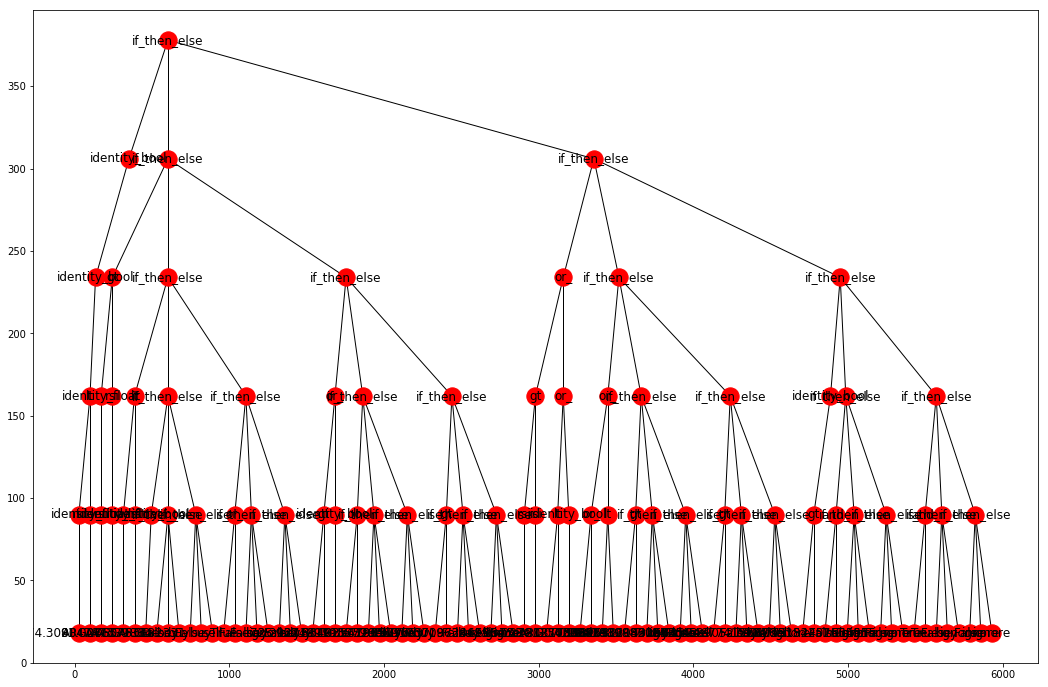

Backtesting report:
--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-01 00:00:00
--
--
2018-04-09 13:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 740627.993139 OMG 	 (1 OMG = 0.00134683 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-09 13:00:00 rsi_value=None
2018-04-12 05:00:00  	 OrderType.SELL   	 cash_balance ->       1069.57 BTC 	 currency_balance -> -740627.993139 OMG 	 (1 OMG = 0.00144776 BTC ), slippage = 0.00
   signal: genetic_down strength=3 trend=-1 horizon=None timestamp=2018-04-12 05:00:00 rsi_value=None
2018-04-12 07:00:00  	 OrderType.BUY    	 cash_balance ->      -1069.57 BTC 	 currency_balance -> 741838.314400 OMG 	 (1 OMG = 0.00143818 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-12 07:00:00 rsi_value=None
2018-04-12 19:00:00  	 OrderType.SELL   	 cash_balance ->       1163.70 BTC 	 currenc

In [4]:
best = e.performance_df_row_info(performance_df.iloc[0])

In [5]:
doge = DogeDNACanvas(best,"container")
HTML(doge.create_container())

In [6]:
Javascript(doge.show())

<IPython.core.display.Javascript object>

### Random thoughts
* perhaps a great doge baby would be found in more generations
* when the market is bearish, some top performing strategies produce no trades (bug or feature?)
* in bullish markets, we see babies that sell and then buy again immediately - unrealistic
